In [38]:
%matplotlib inline

import torch
import torch.nn as nn
import random
import numpy as np
from qpthlocal.qp import QPFunction
from qpthlocal.qp import QPSolvers
from qpthlocal.qp import make_gurobi_model
import pickle
import argparse
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [39]:
def make_matching_matrix(n):
    
    # n is num elements?
    lhs = list(range(n))
    rhs = list(range(n, 2*n))
    
    # n_vars is 1 per possible edge?
    n_vars = len(lhs)*len(rhs)
    # n_constraints is 1 for each lhs, 1 for each rhs, 1 per edge?
    n_constraints = len(lhs) + len(rhs) + n_vars
    A = np.zeros((n_constraints, n_vars))
    b = np.zeros((n_constraints))
    curr_idx = 0
    edge_idx = {}
    # get an index per edge
    for u in lhs:
        for v in rhs:
            edge_idx[(u,v)] = curr_idx
            curr_idx += 1
    # A has rows of 2n elements, followed by n^2 edges
    # A has cols of n^2 edges (so A @ x where x is edges)
    for u in lhs:
        for v in rhs:
            # for u, flip on coefficient for only its outgoing edges
            A[u, edge_idx[(u,v)]] = 1
            # for v, flip on coefficient for only its incoming edges
            A[v, edge_idx[(u,v)]] = 1
            # for the edge itself, flip on a single -1 at its point only
            A[len(lhs)+len(rhs)+edge_idx[(u,v)], edge_idx[(u,v)]] = -1
    
    # each element can have only 1 edge turned on in x
    for u in lhs:
        b[u] = 1
    for u in rhs:
        b[u] = 1
    
    
    return A, b


In [40]:
A, b = make_matching_matrix(10)
A = torch.from_numpy(A).float()
b = torch.from_numpy(b).float()
gamma = 0.001
model_params_quad = make_gurobi_model(A.detach().numpy(), b.detach().numpy(), None, None, gamma*np.eye(A.shape[1]))


In [41]:
c_rand = -torch.rand(100, requires_grad=True)

In [42]:
func = QPFunction(verbose=False, solver=QPSolvers.GUROBI, model_params=model_params_quad)

In [43]:
# Q is gamma * I
# we're not batching

match = func(gamma*torch.eye(A.shape[1]), c_rand, A, b, torch.Tensor(), torch.Tensor())

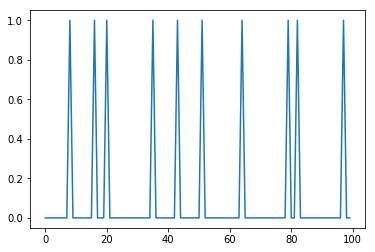

In [44]:
plt.plot(match.detach().numpy().flatten())

In [45]:
match.sum().backward()

## plan for dynamic setting:
- d types
- pool of elements curr_elem each with type (n at each time step)
- known edge weights between each type (?) e_weight (size n^2, recomputed at each time step)
- learned_coeff weights modify known edge weights (weights for each type, effectively pair of types, so d of these)
- perform match, true value of match is e_weight * x
- remove elements, recreate curr_elem, recreate e_weight

some thoughts: encoding type of pool of elements should be either LongTensor or one-hot so can get gradients after indexing



In [46]:
d=10
rand_d_weights = torch.rand(d, requires_grad=True)

In [47]:
n = 20
rand_types_pool = torch.randint(d,(n,))

In [48]:
curr_weights = rand_d_weights[rand_types_pool]

In [49]:
rand_e_weight = torch.rand(n,n) # in reality should be based on types (but not on weights)

In [50]:
modified_edge_weights = rand_e_weight + 0.5*(torch.unsqueeze(curr_weights,0) + torch.unsqueeze(curr_weights, 1))

In [51]:
A, b = make_matching_matrix(n)
A = torch.from_numpy(A).float()
b = torch.from_numpy(b).float()
gamma = 0.0001
model_params_quad = make_gurobi_model(A.detach().numpy(), b.detach().numpy(), None, None, gamma*np.eye(A.shape[1]))

In [52]:
func = QPFunction(verbose=False, solver=QPSolvers.GUROBI, model_params = model_params_quad)

In [53]:
resulting_match = func(gamma*torch.eye(A.shape[1]), -modified_edge_weights.view(-1), A, b, torch.Tensor(), torch.Tensor()).view(20,20)

In [54]:
modified_edge_weights

tensor([[1.1565, 1.2402, 0.6435, 0.8565, 1.6944, 0.9980, 1.3214, 0.7546, 1.2610,
         1.1764, 1.7086, 1.1603, 0.9426, 0.9583, 1.4080, 0.9775, 1.2730, 0.6769,
         1.4184, 1.5539],
        [1.6209, 0.9691, 1.2742, 1.4351, 1.2322, 0.4024, 0.8509, 1.1922, 0.5334,
         1.7182, 0.7776, 0.5964, 1.4020, 0.9951, 1.2951, 0.9103, 1.6365, 0.7447,
         1.2791, 1.5313],
        [1.2172, 1.1555, 0.5692, 1.0331, 1.2570, 0.2293, 1.2200, 0.3511, 0.6558,
         1.2499, 1.0083, 0.9076, 1.0890, 0.6022, 0.4998, 0.4206, 1.2687, 0.7886,
         0.4907, 0.6925],
        [0.8531, 1.5134, 0.4940, 1.3766, 0.7346, 0.9543, 0.7943, 1.1860, 0.5174,
         1.0277, 0.8232, 1.0345, 1.3804, 0.9274, 0.9800, 0.5946, 1.4564, 0.8396,
         1.0857, 1.3822],
        [1.1394, 1.1064, 1.1380, 1.6084, 1.0480, 1.2398, 1.4775, 0.7414, 0.8145,
         0.8989, 1.3906, 0.4673, 0.8979, 1.1631, 1.2721, 0.7128, 1.1338, 1.1739,
         0.8463, 0.8778],
        [0.4590, 0.8866, 0.0516, 1.1418, 0.5018, 0.0421, 0.9

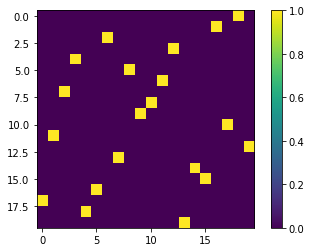

In [55]:
plt.imshow(resulting_match.detach().numpy())
plt.colorbar()

In [56]:
true_cost = torch.sum(resulting_match * rand_e_weight)

In [57]:
true_cost

tensor(18.5048, grad_fn=<SumBackward0>)

next step: decide on arrival/departure model -- presumably it should be type-dependent (one rare type with one really good edge to one other type)

In [58]:
type_arrival_rates = torch.rand(d)
type_departure_probs = torch.rand(d)

In [59]:
torch.max(resulting_match, 0).values != 1

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1],
       dtype=torch.uint8)

In [60]:
new_match = resulting_match.clone()

In [61]:
new_match[19,15] = 0.0

In [62]:
new_match[16,0] = 0.0

In [63]:
torch.poisson(type_arrival_rates)

tensor([0., 1., 1., 0., 0., 2., 1., 1., 0., 0.])

In [64]:
def ind_counts_to_longs(arrival_counts):
    # optimize later
    results = []
    for i in range(arrival_counts.shape[0]):
        for j in range(arrival_counts[i].long().item()):
            results.append(i)
    return torch.LongTensor(results)

In [65]:
ind_counts_to_longs(torch.poisson(type_arrival_rates))

tensor([0, 2, 4, 5, 5, 6, 7, 8, 8, 9, 9])

In [66]:
def step_simulation(current_elems, match_edges, type_arrival_rates, type_departure_probs, match_thresh=0.8):
    # first match elements
    pool_after_match = current_elems[torch.max(match_edges, 0).values <= match_thresh]
    
    # now handle departures
    if pool_after_match.shape[0] > 0:
        remaining_elements_depart_prob = type_departure_probs[pool_after_match]
        remain = torch.bernoulli(1 - remaining_elements_depart_prob).nonzero().view(-1)
        remaining_elements = pool_after_match[remain]
    else:
        remaining_elements = pool_after_match
    
    # now get new elements (poisson?)
    after_arrivals = torch.cat((remaining_elements, ind_counts_to_longs(torch.poisson(type_arrival_rates))))
    
    return after_arrivals

In [67]:
step_simulation(rand_types_pool, new_match, type_arrival_rates, type_departure_probs)

tensor([2, 4, 6, 7, 8, 9])

In [68]:
type_departure_probs[9] = 0.1

In [69]:
def edge_matrix(current_elems, e_weights_by_type):
    # compute the matrix of edge weights by type of each element
    # should actually be shaped as matrix, will be flattened later
    
    # optimize later
    edge_mat = torch.zeros((current_elems.shape[0], current_elems.shape[0]))
    for i in range(current_elems.shape[0]):
        for j in range(current_elems.shape[0]):
            u = current_elems[i]
            v = current_elems[j]
            edge_mat[i, j] = e_weights_by_type[u, v]
            
    return edge_mat

In [70]:
xx = torch.rand((d,d))
e_weights_by_type_rand = (xx + xx.t())

In [71]:
edge_matrix(rand_types_pool, e_weights_by_type_rand)

tensor([[0.8819, 1.2909, 1.1479, 0.6342, 1.3248, 0.8956, 0.0989, 0.0989, 0.9316,
         1.3248, 1.6043, 0.8956, 0.0989, 1.2909, 0.8819, 0.6342, 0.8819, 0.8956,
         0.6342, 0.0989],
        [1.2909, 0.4162, 0.8457, 0.8861, 1.3195, 0.9462, 1.2401, 1.2401, 0.8848,
         1.3195, 1.1013, 0.9462, 1.2401, 0.4162, 1.2909, 0.8861, 1.2909, 0.9462,
         0.8861, 1.2401],
        [1.1479, 0.8457, 0.6578, 1.5222, 0.5225, 1.3626, 1.3665, 1.3665, 0.6064,
         0.5225, 0.9710, 1.3626, 1.3665, 0.8457, 1.1479, 1.5222, 1.1479, 1.3626,
         1.5222, 1.3665],
        [0.6342, 0.8861, 1.5222, 1.6126, 0.7190, 1.2831, 0.7423, 0.7423, 1.3816,
         0.7190, 0.7232, 1.2831, 0.7423, 0.8861, 0.6342, 1.6126, 0.6342, 1.2831,
         1.6126, 0.7423],
        [1.3248, 1.3195, 0.5225, 0.7190, 1.4013, 0.7604, 1.0114, 1.0114, 1.3470,
         1.4013, 0.7157, 0.7604, 1.0114, 1.3195, 1.3248, 0.7190, 1.3248, 0.7604,
         0.7190, 1.0114],
        [0.8956, 0.9462, 1.3626, 1.2831, 0.7604, 0.2725, 0.9

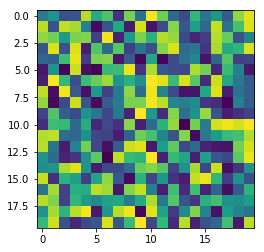

In [72]:
plt.imshow(rand_e_weight.numpy())

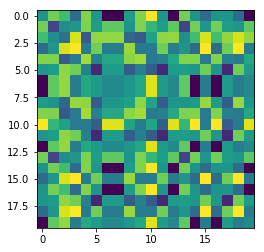

In [73]:
plt.imshow(edge_matrix(rand_types_pool, e_weights_by_type_rand).numpy())

In [74]:
e_weights_by_type_rand

tensor([[0.4162, 0.9462, 1.2909, 0.8861, 1.2401, 0.9692, 1.1013, 0.8848, 1.3195,
         0.8457],
        [0.9462, 0.2725, 0.8956, 1.2831, 0.9346, 1.4197, 0.5458, 0.5459, 0.7604,
         1.3626],
        [1.2909, 0.8956, 0.8819, 0.6342, 0.0989, 1.3870, 1.6043, 0.9316, 1.3248,
         1.1479],
        [0.8861, 1.2831, 0.6342, 1.6126, 0.7423, 1.6786, 0.7232, 1.3816, 0.7190,
         1.5222],
        [1.2401, 0.9346, 0.0989, 0.7423, 0.8114, 1.8555, 1.5462, 0.8917, 1.0114,
         1.3665],
        [0.9692, 1.4197, 1.3870, 1.6786, 1.8555, 1.3506, 1.3086, 0.7409, 0.5767,
         1.1619],
        [1.1013, 0.5458, 1.6043, 0.7232, 1.5462, 1.3086, 0.9917, 0.9804, 0.7157,
         0.9710],
        [0.8848, 0.5459, 0.9316, 1.3816, 0.8917, 0.7409, 0.9804, 0.9672, 1.3470,
         0.6064],
        [1.3195, 0.7604, 1.3248, 0.7190, 1.0114, 0.5767, 0.7157, 1.3470, 1.4013,
         0.5225],
        [0.8457, 1.3626, 1.1479, 1.5222, 1.3665, 1.1619, 0.9710, 0.6064, 0.5225,
         0.6578]])

In [117]:
# type_weights is the learned parameter

def compute_matching(current_elems, curr_type_weights, e_weights_by_type, gamma=0.00001):
    n = current_elems.shape[0]
    A, b = make_matching_matrix(n)
    A = torch.from_numpy(A).float()
    b = torch.from_numpy(b).float()
    # for some reason we need this randomness to end up with an actual matching
    e_weights = edge_matrix(current_elems, e_weights_by_type)
    jitter_e_weights = e_weights + 1e-4*torch.rand(n,n)
    #e_weights = torch.rand(n,n)
    model_params_quad = make_gurobi_model(A.detach().numpy(), b.detach().numpy(), None, None, gamma*np.eye(A.shape[1]))
    func = QPFunction(verbose=False, solver=QPSolvers.GUROBI, model_params=model_params_quad)
    
    Q_mat = gamma*torch.eye(A.shape[1])
    
    curr_elem_weights = curr_type_weights[current_elems]
    modified_edge_weights = jitter_e_weights - 0.5*(torch.unsqueeze(curr_elem_weights,0) + torch.unsqueeze(curr_elem_weights,1))
    # may need some negative signs
    resulting_match = func(Q_mat, -modified_edge_weights.view(-1), A, b, torch.Tensor(), torch.Tensor()).view(n,n)
    return resulting_match, e_weights

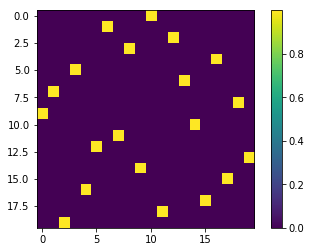

In [118]:
plt.imshow(new_match.detach().numpy())
plt.colorbar()

In [119]:
loss = torch.sum(new_match*e_weights)


# a toy problem

- d=5 types
- type 0: arrives rarely, departs fast
- type 1,2,3,4 arrive and depart reasonably
- edge weights: 0-1 very good 10, 0-234 don't exist, all others 0.1 or whatever
- should learn some small weight not to match 1, hopefully

In [121]:
def toy_e_weights_type():
    mat = 0.1*torch.ones(5,5)
    mat[0,1] = 10.0
    mat[1,0] = 10.0
    mat[0,0] = 0.0
    mat[0,2:5] = 0.0
    mat[2:5,0] = 0.0
    return mat

toy_arrival_rates = torch.Tensor([0.1,1.0,1.0,1.0,1.0])
toy_departure_probs = torch.Tensor([0.9,0.1,0.1,0.1,0.1])

In [124]:
def train_func(n_rounds=30, n_epochs=10):
    n_rounds = 30
    n_epochs = 10
    e_weights_type = toy_e_weights_type()
    init_pool = torch.LongTensor([1,1,2,2])
    type_weights = torch.ones(5, requires_grad=True)
    optimizer = torch.optim.Adam([type_weights], lr=1e-1, weight_decay=1e-1)
    for e in range(n_epochs):
        losses = []
        print(f"epoch {e}")
        curr_pool = init_pool.clone()
        for r in range(n_rounds):
            resulting_match, e_weights = compute_matching(curr_pool, type_weights, e_weights_type)
            losses.append(-1.0*torch.sum(resulting_match * e_weights))
            curr_pool = step_simulation(curr_pool, resulting_match, toy_arrival_rates, toy_departure_probs)
        total_loss = torch.sum(torch.stack(losses))
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
    return type_weights

In [125]:
%prun train_func()

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
 

         4418136 function calls in 70.127 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       10   29.888    2.989   29.888    2.989 {method 'run_backward' of 'torch._C._EngineBase' objects}
  1147998   18.151    0.000   18.151    0.000 qp.py:92(<genexpr>)
      300    7.061    0.024    7.663    0.026 qp.py:110(forward_gurobi_prebuilt)
      300    5.576    0.019   27.940    0.093 qp.py:67(make_gurobi_model)
      300    3.170    0.011    3.172    0.011 <ipython-input-69-416ed2bc4481>:1(edge_matrix)
      300    1.996    0.007    1.996    0.007 {method 'nonzero' of 'numpy.ndarray' objects}
   299901    1.004    0.000   19.255    0.000 {gurobipy.quicksum}
      300    0.680    0.002    0.680    0.002 qp.py:77(<listcomp>)
      900    0.316    0.000    0.316    0.000 {built-in method numpy.zeros}
      300    0.311    0.001    0.311    0.001 qp.py:124(<listcomp>)
      300    0.273    0.001    0.273    0.001 qp.py:119(<lis